In [1]:
#!pip install netcdf4
#!pip install rioxarray
#!pip install regionmask

import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
import os
import regionmask
sys.path.append(r'C:\repos\snkit\src')
sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
from ci_adapt_utilities import *
from ci_adapt_classes import *
from shapely import Point
import ast


from datetime import datetime

In [2]:
!config.py

In [3]:
config_file = r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

# Set paths and data sources
p = Path('..')
miraca_data = Path(r'N:\Projects\11209000\11209175\B. Measurements and calculations\Data')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'event_data_inspection'/ 'overlapping_floods_shapefiles'

# MIRACA color scheme
color_string = config.get('DEFAULT', 'miraca_colors')
miraca_colors = ast.literal_eval(color_string)



In [4]:
# Functions definition

#filter the discharge dataset to the desired time range and bounding box
def find_max_discharge_in_basin(basin_path, discharge_nc):
    # Load basin and find bounding box
    basin = gpd.read_file(basin_path)
    lon1,lat1,lon2,lat2 = get_bbox(basin_path)

    # Load discharge data and filter to the bounding box
    thresholds_mu = xr.open_dataset(discharge_nc).sel(lon = slice(lon1,lon2), lat = slice(lat2,lat1))

    # Mask the discharge data to the basin
    basin_mask = regionmask.mask_geopandas(basin, thresholds_mu)
    inverted_basin_mask = basin_mask.where(basin_mask.isnull(), -1)
    inverted_basin_mask = inverted_basin_mask.where(inverted_basin_mask.notnull())
    thresholds_mu_masked = thresholds_mu.where(inverted_basin_mask.notnull())

    # Find the lat lon with the highest discharge value within the basin
    max_dis_mu = thresholds_mu_masked['mu'].max()
    max_dis_mu_lon = thresholds_mu_masked['lon'].where(thresholds_mu_masked['mu'] == max_dis_mu).values
    max_dis_mu_lat = thresholds_mu_masked['lat'].where(thresholds_mu_masked['mu'] == max_dis_mu).values
    max_dis_mu_lon = max_dis_mu_lon[~np.isnan(max_dis_mu_lon)]
    max_dis_mu_lat = max_dis_mu_lat[~np.isnan(max_dis_mu_lat)]

    try:
        return max_dis_mu.values, (max_dis_mu_lon[0], max_dis_mu_lat[0])
    except Exception as e:
        print(f'Error in find_max_discharge_in_basin: {basin_path}')
        print(e)
        return None, (None, None)

def get_bbox(path):
    gdf = gpd.read_file(path)
    gdf = gdf.to_crs('epsg:4326')
    return gdf.total_bounds

# Find the peak discharge at a location over several timesteps
def get_peak_discharge(discharge_data,lon, lat, t0, t1):
    # print(f'Search coords: {lon}, {lat}')
    if lat == None or lon == None or t0 == None or t1 == None:
        return None, None
    # Find time range
    year_start = t0.year
    year_end = t1.year
    if year_start != year_end:
        years = [str(year) for year in range(year_start, year_end+1)]
    else:
        years = [str(year_start)]

    # Open the data for the year and location specified
    max_discharges = {}
    for year in years:
        try:
            discharge_nc = f'dis.HERA{year}.nc'
            t_0_minus_1_week = t0 - pd.Timedelta(7, unit='d')
            t_1_plus_1_week = t1 + pd.Timedelta(7, unit='d')
            discharge = xr.open_dataset(discharge_data / discharge_nc).sel(time=slice(t_0_minus_1_week, t_1_plus_1_week),lon = slice(lon - 0.025, lon + 0.025), lat = slice(lat + 0.025, lat - 0.025))
            discharge = discharge.sel(lon=lon, lat=lat, method='nearest')
            #print(f'discharge read from coords: {discharge.lon.values}, {discharge.lat.values}')
            distance_between_in_out=(discharge.lon.values - lon, discharge.lat.values - lat)
            #print(f'distance between points: {distance_between_in_out}')
            if distance_between_in_out[0]>0.005 or distance_between_in_out[1]>0.005:
                print(f'Warning: distance between points is greater than 0.005 degrees: {distance_between_in_out}')
            # Find the maximum value of the timeseries and the time of occurrence
            max_discharge = discharge['dis'].max()
            for t in discharge.time:
                if max_discharge.values is not None:
                    max_discharges[t.values] = max_discharge.values
                else:
                    break
            
            # If there is no discharge in the area (catchment area too small), discharge is 0
            if len(max_discharges) == 0:
                peak_discharge = 0
                peak_time = 0
            else:
                peak_discharge = max(max_discharges.values())
                peak_time = [k for k, v in max_discharges.items() if v == peak_discharge][0]
                pt=datetime.strptime(str(peak_time), '%Y-%m-%dT%H:%M:%S.%f000000')
                # if pt < t0 or pt > t1:
                #     print(f'Peak time {peak_time} is not within the specified time range {t0} - {t1}')        
        except Exception as e:
            print(f'Error in get_peak_discharge for year {year}: {e}')
            return None, None

    return peak_discharge, pt

# For a given coordenate, find the threshold discharge values for all the return periods
def find_threshold_discharge_at_point(thresholds_ncs, lon, lat):
    rp_thresholds = [rp for rp in os.listdir(thresholds_ncs) if rp.endswith('.nc')]
    thresholds_dict = {}
    for thresholds_nc in rp_thresholds:
        try:
            rp=float(thresholds_nc.split('_')[-1].split('.n')[0])
        except ValueError:
            continue
        
        threshold = xr.open_dataset(thresholds_ncs/thresholds_nc).sel(lon = lon, lat = lat, method = 'nearest')
        thresholds_dict[rp] = threshold['rl_'+str(rp)].values

    return thresholds_dict

# Interpolate the return period for a given discharge value 
def interp_discharge_rp(peak_discharge, rp_thresholds):
    
    rps=[float(x) for x in rp_thresholds.keys()]
    discharge_thresholds=[float(rp_thresholds[rp]) for rp in rps]
    try:
        if float(peak_discharge)<float(discharge_thresholds[0]):
            return 0
        rp=np.interp(float(peak_discharge),discharge_thresholds,rps)
        return rp
    except TypeError:
        pass


In [5]:
# Find the coordinates of the highest discharge value in each basin

thresholds_ncs = data_path / 'Floods/flood_thresholds_efas'
discharge_mu_nc = thresholds_ncs / 'flood_threshold_efas_v5.1_mu.nc'
basins_path = data_path / 'Floods/basins'
basins = [f for f in os.listdir(basins_path) if f.endswith('.shp')]
discharge_sample_points = {}

for basin in basins:
    basin_id = basin.split('_')[-1].split('.')[0]
    basin_path = basins_path / basin
    max_dis_mu, (max_dis_mu_lon, max_dis_mu_lat) = find_max_discharge_in_basin(basin_path, discharge_mu_nc)
    discharge_sample_points[basin_id] = (max_dis_mu_lon, max_dis_mu_lat)


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\regionmask\core\_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


Error in find_max_discharge_in_basin: C:\Data\Floods\basins\hybas_eu_2080418720.shp
index 0 is out of bounds for axis 0 with size 0


In [6]:
basin_thresholds_dict={}
for basin_id, (lon, lat) in discharge_sample_points.items():   
    basin_thresholds_dict[basin_id] = dict(sorted(find_threshold_discharge_at_point(thresholds_ncs, lon, lat).items()))

In [7]:
basin_thresholds_dict['2080410170']

{1.5: array(128.58272, dtype=float32),
 2.0: array(144.73708, dtype=float32),
 5.0: array(184.49251, dtype=float32),
 10.0: array(210.81407, dtype=float32),
 20.0: array(236.06235, dtype=float32),
 50.0: array(268.74365, dtype=float32),
 100.0: array(293.23367, dtype=float32),
 200.0: array(317.63434, dtype=float32),
 500.0: array(349.82642, dtype=float32)}

In [8]:
pd.DataFrame.from_dict(discharge_sample_points, orient='index', columns=['lon', 'lat']).head(1)
#pd.DataFrame.from_dict(discharge_sample_points, orient='index', columns=['lon', 'lat']).to_csv(data_path / 'interim/discharge_sample_points.csv')

,lon,lat
2080410170,7.858333,50.808334


In [9]:
floods_df = pd.read_csv(r'C:\Data\Floods\Paprotny Flood Events Data\HANZE_potential_flood_catalogue_all.csv')
floods_df = floods_df[floods_df['Country code'] == 'DE']
floods_df = floods_df[floods_df['Type'] == 'River']
floods_df.sort_values(by = 'Return period', inplace = True, ascending = True)

events = os.listdir(interim_data_path)
events = [e for e in events if e.endswith('.shp')]

event_basin_overlaps = pd.read_csv(r'C:\Data\interim\event_data_inspection\overlapping_floods_shapefiles\hybas_id_event_overlaps.csv', index_col = 0)


In [11]:
discharge_data = miraca_data/'HERA_data/river_discharge'
target = data_path / 'interim/peak_discharges_paprotny_events_basins_2.csv'
peak_discharges = {}

for event in tqdm(events, desc = 'Processing events', total = len(events)):
    event_path = interim_data_path/event
    event_name = os.path.basename(event_path).split('.')[0]
    event_id = str(event_name.split('_')[1])

    if len(floods_df[floods_df['ID'] == int(event_id)]) == 0:
        continue

    event_start_date = datetime.strptime(floods_df[floods_df['ID'] == int(event_id)]['Start date'].values[0], '%d/%m/%Y')
    event_end_date = datetime.strptime(floods_df[floods_df['ID'] == int(event_id)]['End date'].values[0], '%d/%m/%Y')
    event_duration = event_end_date-event_start_date

    try:
        event_matches = event_basin_overlaps.loc[event].dropna().to_list()
    except KeyError:
        continue

    for basin_id in event_matches:
        lon, lat = discharge_sample_points[str(int(basin_id))]

        peak_discharges[event, str(int(basin_id))] = get_peak_discharge(discharge_data,
                                t0 = event_start_date,
                                t1 = event_end_date,
                                lon = lon,
                                lat = lat)

peak_discharges_df = pd.DataFrame.from_dict(peak_discharges, orient='index', columns=['peak_discharge', 'peak_time'])        
peak_discharges_df.to_csv(target, mode='a', header=True)  


Processing events: 100%|██████████| 532/532 [3:55:19<00:00, 26.54s/it]  


In [13]:
# Interpolate the return period for each event and basin
events_rp={}
for (event, basin_id), (peak_dis, peak_time) in peak_discharges.items():
    events_rp[event, basin_id]=interp_discharge_rp(peak_dis, basin_thresholds_dict[basin_id])


In [51]:
# peak_discharges_df = pd.DataFrame.from_dict(peak_discharges, orient='index', columns=['peak_discharge', 'peak_time'])
peak_discharges_df = pd.DataFrame(list(peak_discharges.values()), index=pd.MultiIndex.from_tuples(peak_discharges.keys()), columns=['peak_discharge', 'peak_time'])
peak_discharges_df['peak_discharge'] = peak_discharges_df['peak_discharge'].astype(float)

peak_discharges_df['event'] = peak_discharges_df.index.get_level_values(0)
peak_discharges_df['basin'] = peak_discharges_df.index.get_level_values(1)
peak_discharges_df['event_rp'] = peak_discharges_df.index.get_level_values(0).map(lambda x: floods_df[floods_df['ID'] == int(x.split('_')[1])]['Return period'].values[0])
peak_discharges_df['calculated_rp'] = peak_discharges_df.apply(lambda x: events_rp[x['event'], x['basin']], axis=1)
peak_discharges_df['event_dates_range'] = peak_discharges_df['event'].apply(lambda x: floods_df[floods_df['ID'] == int(x.split('_')[1])]['Start date'].values[0] + ' - ' + floods_df[floods_df['ID'] == int(x.split('_')[1])]['End date'].values[0])

peak_discharges_df

peak_discharge  peak_time  \
Event_28000_DE_1950_River.shp 2080421680      113.889282 1950-01-25   
                              2080410170       65.941650 1950-01-25   
                              2080429430     2272.067139 1950-01-25   
                              2080429540        3.896362 1950-01-25   
                              2080429670     2283.008301 1950-01-25   
...                                                  ...        ...   
Event_28900_DE_2020_River.shp 2080446320     1340.139771 2020-12-15   
                              2080447840     1327.547241 2020-12-15   
                              2080451930       58.472168 2020-12-15   
                              2080447970       13.683960 2020-12-15   
                              2080448120       14.840759 2020-12-15   

                                                                  event  \
Event_28000_DE_1950_River.shp 2080421680  Event_28000_DE_1950_River.shp   
                              2080410170  Event_28000_DE_1950_River.shp   
                              2080429430  Event_28000_DE_1950_River.shp   
                              2080429540  Event_28000_DE_1950_River.shp   
                              2080429670  Event_28000_DE_1950_River.shp   
...                                                                 ...   
Event_28900_DE_2020_River.shp 2080446320  Event_28900_DE_2020_River.shp   
                              2080447840  Event_28900_DE_2020_River.shp   
                              2080451930  Event_28900_DE_2020_River.shp   
                              2080447970  Event_28900_DE_2020_River.shp   
                              2080448120  Event_28900_DE_2020_River.shp   

                                               basin  event_rp  calculated_rp  \
Event_28000_DE_1950_River.shp 2080421680  2080421680    253.66            0.0   
                              2080410170  2080410170    253.66            0.0   
                              2080429430  2080429430    253.66            0.0   
                              2080429540  2080429540    253.66            0.0   
                              2080429670  2080429670    253.66            0.0   
...                                              ...       ...            ...   
Event_28900_DE_2020_River.shp 2080446320  2080446320      1.40            0.0   
                              2080447840  2080447840      1.40            0.0   
                              2080451930  2080451930      1.40            0.0   
                              2080447970  2080447970      1.40            0.0   
                              2080448120  2080448120      1.40            0.0   

                                                event_dates_range  
Event_28000_DE_1950_River.shp 2080421680  01/02/1950 - 17/02/1950  
                              2080410170  01/02/1950 - 17/02/1950  
                              2080429430  01/02/1950 - 17/02/1950  
                              2080429540  01/02/1950 - 17/02/1950  
                              2080429670  01/02/1950 - 17/02/1950  
...                                                           ...  
Event_28900_DE_2020_River.shp 2080446320  22/12/2020 - 31/12/2020  
                              2080447840  22/12/2020 - 31/12/2020  
                              2080451930  22/12/2020 - 31/12/2020  
                              2080447970  22/12/2020 - 31/12/2020  
                              2080448120  22/12/2020 - 31/12/2020  

[19602 rows x 7 columns]

In [52]:
# peak_discharges_df.to_csv(data_path / 'interim/peak_discharges_paprotny_events_basins_RheinlandPalatinate_1.csv', decimal=',', sep=';') 

In [10]:
peak_discharges_df=pd.read_csv(data_path / 'interim/peak_discharges_paprotny_events_basins_RheinlandPalatinate_0.csv', decimal=',', sep=';')

In [31]:
event_name_check = 'Event_28431_DE_1990_River.shp'
basin_id_check = 2080411370

peak_discharges_df.loc[(peak_discharges_df['event']==event_name_check) & (peak_discharges_df['basin']==basin_id_check)]

,Unnamed: 0,Unnamed: 1,peak_discharge,peak_time,event,basin,event_rp,calculated_rp,event_dates_range
1000,Event_28431_DE_1990_River.shp,2080411370,5553.62,3-2-1990,Event_28431_DE_1990_River.shp,2080411370,2.18,1.79,10/02/1990 - 22/02/1990


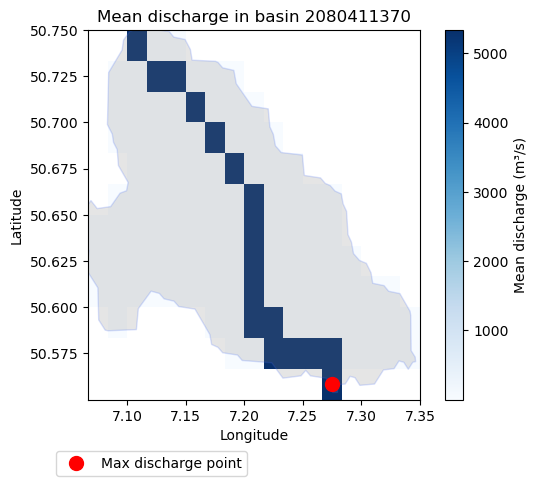

In [32]:
# Mean discharge visualization for a basin
basins = [f for f in os.listdir(basins_path) if f.endswith('.shp')]

# Select a basin and find the coordinates of the highest discharge value
basin_filt = [bas for bas in basins if str(basin_id_check) in bas][0]
basin_id = basin_filt.split('_')[-1].split('.')[0]
basin_path = basins_path / basin_filt
max_dis_mu, (max_dis_mu_lon, max_dis_mu_lat) = find_max_discharge_in_basin(basin_path, discharge_mu_nc)
discharge_sample_points[basin_id] = (max_dis_mu_lon, max_dis_mu_lat)

# Retrieve discharge data for the basin
discharge_mu = xr.open_dataset(discharge_mu_nc)
bbox_basin = get_bbox(basin_path)
lon1,lat1,lon2,lat2 = bbox_basin
discharge_mu = discharge_mu.sel(lon = slice(lon1,lon2), lat = slice(lat2,lat1))

# Now filter the values that are strictly within the basin
basin = gpd.read_file(basin_path)
basin_mask = regionmask.mask_geopandas(basin, discharge_mu)

# Replace NaNs with -1 and valid region numbers with NaNs
inverted_basin_mask = basin_mask.where(basin_mask.isnull(), -1)
inverted_basin_mask = inverted_basin_mask.where(inverted_basin_mask.notnull())

# Apply the inverted mask
discharge_mu_masked = discharge_mu.where(inverted_basin_mask.notnull())

# Plot the basin and the discharge data
fig, ax = plt.subplots()

# Plot the discharge data
dsplot = discharge_mu_masked
dsplot['mu'].plot(ax = ax, cmap = 'Blues', cbar_kwargs = {'label': 'Mean discharge (m³/s)'})

# Find the lat lon with the highest mean discharge value within the basin
max_mu_dis = dsplot['mu'].max()
max_mu_dis_lon = dsplot['lon'].where(dsplot['mu'] == max_mu_dis).values
max_mu_dis_lat = dsplot['lat'].where(dsplot['mu'] == max_mu_dis).values

#remove all the nans   
max_mu_dis_lon = max_mu_dis_lon[~np.isnan(max_mu_dis_lon)]
max_mu_dis_lat = max_mu_dis_lat[~np.isnan(max_mu_dis_lat)]

# Plot the basin boundary
basin.plot(ax = ax, facecolor = 'none', edgecolor = miraca_colors['primary blue'], color = 'grey', alpha = 0.2)

# plot the max mean discharge point
ax.plot(max_mu_dis_lon, max_mu_dis_lat, 'ro', markersize = 10)

# Add labels, title, and legend to the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Mean discharge in basin {basin_id}')
ax.legend(['Max discharge point'], bbox_to_anchor=(0.5, -0.12))

plt.show()


In [33]:
# Create visualisation for the basin and the discharge points
from lonboard import Map, PolygonLayer, ScatterplotLayer

# Generate the discharge points layer
discharge_points = gpd.GeoDataFrame(
    {'geometry': [Point(lon, lat) for bas_id, (lon, lat) in discharge_sample_points.items() 
                  if (lon is not None and lat is not None) and bas_id==basin_id]},
                  crs='EPSG:4326')

if not discharge_points.empty:
    layer_discharge_pts = ScatterplotLayer.from_geopandas(discharge_points,
    get_fill_color=miraca_colors['red_danger'],
    get_radius=200,
    auto_highlight=True,
    opacity=0.8)
else:
    layer_discharge_pts = None
    
# Set path for basin to add to visualization
basin_path = rf'C:\Data\Floods\basins\hybas_eu_{int(basin_id)}.shp'

# Generate the basin layer
basin = gpd.read_file(basin_path)
layer_basin = PolygonLayer.from_geopandas(basin,
    get_fill_color=miraca_colors['grey_100'],
    get_line_color=miraca_colors['green_900'], get_line_width=100,
    auto_highlight=False,
    filled=False)

# Flood return period: H for frequent(RP10-20), M for 100 year return period (RP100) and L for extreme (RP2000)
return_period_str='M'
# Generate flood layers and protection layers for visualization
flood_plot_path=rf'Floods\Germany\basin_intersections\DERP_RW_{return_period_str}_4326_hybas_intersections\flood_DERP_RW_{return_period_str}_4326_{basin_id}.geojson'
flood_m = data_path / flood_plot_path
flood_gdf=gpd.read_file(flood_m)
layers_flood=[]
f_area_colors = {1:'blue', 3:'green'}
for f_area in flood_gdf.flood_area.unique():
    for f_depth in flood_gdf.depth_class.unique():
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            layers_flood.append(PolygonLayer.from_geopandas(subset_gdf, 
                                                            get_fill_color=miraca_colors[color_key], 
                                                            opacity=0.5, 
                                                            stroked=False))

layers=[]
if layer_basin is not None:
    layers.append(layer_basin)
else:
    print('No basin layer')
if layers_flood is not None:
    layers.extend(layers_flood)
else:
    print('No flood layers')
if layer_discharge_pts is not None:
    layers.append(layer_discharge_pts)
else:
    print('No discharge points layer')
Voyager = 'https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json'

m = Map(layers, show_tooltip=True, basemap_style=Voyager) 

m


Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[PolygonLayer(filled=…

In [34]:
# Produce figure of discharge data for a basin over a given event
event = event_name_check

# Pick the starting time of the event, if peak time is before the event start, pick the peak time, else pick the event start time

if peak_discharges_df.loc[(peak_discharges_df['event']==event) & (peak_discharges_df['basin']==basin_id)]['peak_time'].values < datetime.strptime(str(floods_df[floods_df['ID'] == int(event.split('_')[1])]['Start date'].values[0]), '%d/%m/%Y'):
    t0 = peak_discharges_df.loc[(event, basin_id)]['peak_time']
else:
    t0 = datetime.strptime(floods_df[floods_df['ID'] == int(event.split('_')[1])]['Start date'].values[0], '%d/%m/%Y')

# Pick the end time of the event, if peak time is after the event end, pick the peak time, else pick the event end time
if peak_discharges_df.loc[(peak_discharges_df['event']==event) & (peak_discharges_df['basin']==basin_id)]['peak_time'].values > datetime.strptime(str(floods_df[floods_df['ID'] == int(event.split('_')[1])]['End date'].values[0]), '%d/%m/%Y'):
    t1 = peak_discharges_df.loc[(event, basin_id)]['peak_time']
else:
    t1 = datetime.strptime(floods_df[floods_df['ID'] == int(event.split('_')[1])]['End date'].values[0], '%d/%m/%Y')

# Check the year of the event and open the corresponding discharge data
year = t0.year
discharge_nc_name = f'dis.HERA{year}.nc'

discharge_hera_nc = miraca_data / 'HERA_data/river_discharge' / discharge_nc_name


bbox_basin = get_bbox(basin_path)
lon1,lat1,lon2,lat2 = bbox_basin

# Load discharge data and filter to the bounding box
discharge=xr.open_dataset(discharge_hera_nc).sel(time=slice(t0, t1),lon = slice(lon1,lon2), lat = slice(lat2,lat1))

# Mask the discharge data
basin = gpd.read_file(basin_path)
basin_mask = regionmask.mask_geopandas(basin, discharge)

# Replace NaNs with -1 and valid region numbers with NaNs
inverted_basin_mask = basin_mask.where(basin_mask.isnull(), -1)
inverted_basin_mask = inverted_basin_mask.where(inverted_basin_mask.notnull())

# Apply the inverted mask
discharge_masked = discharge.where(inverted_basin_mask.notnull())

# Get the number of time steps
num_time_steps = len(discharge_masked['time'])

# Calculate the number of rows and columns for the subplots
num_rows = int(np.sqrt(num_time_steps))
num_cols = num_time_steps // num_rows + (num_time_steps % num_rows > 0)

# Find global min and max values
vmin = discharge_masked['dis'].min().values
vmax = discharge_masked['dis'].max().values

fig, axs = plt.subplots(num_rows, num_cols, figsize=(150, 150))
fig.suptitle(f'Event: {event}, Basin: {basin_id}, Max Discharge: {vmax}', fontsize=16)


for i, time in enumerate(discharge_masked['time']):
    ax = axs[i // num_cols, i % num_cols]
    discharge_masked['dis'].sel(time=time).plot.imshow(ax=ax, cmap='Blues', vmin=vmin, vmax=vmax)
    # basin.plot(ax = ax, facecolor = 'none', edgecolor = miraca_colors['primary blue'], color = 'grey', alpha = 0.2)
    ax.set_title(f'Time: {time.values}')

plt.subplots_adjust(top=0.9)
plt.tight_layout()

fig_name = f'{event}_Basin_{basin_id}_Discharge.png'

plt.savefig(data_path/ 'interim/figures' /fig_name, dpi=75)

plt.close(fig)

# plt.show()


C:\Users\peregrin\AppData\Local\Temp\ipykernel_18340\4165096224.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if peak_discharges_df.loc[(peak_discharges_df['event']==event) & (peak_discharges_df['basin']==basin_id)]['peak_time'].values < datetime.strptime(str(floods_df[floods_df['ID'] == int(event.split('_')[1])]['Start date'].values[0]), '%d/%m/%Y'):
C:\Users\peregrin\AppData\Local\Temp\ipykernel_18340\4165096224.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if peak_discharges_df.loc[(peak_discharges_df['event']==event) & (peak_discharges_df['basin']==basin_id)]['peak_time'].values > datetime.strptime(str(floods_df[floods_df['ID'] == int(event.split('_')[1])]['End date'].values[0]), '%d/%m/%

In [28]:
path=r'N:\Projects\11209000\11209175\B. Measurements and calculations\Data\HERA_data\river_discharge\dis.HERA1990.nc'
discharge_check=xr.open_dataset(path)

In [30]:
discharge_check.isel()

IndexError: index 640202400000000000 is out of bounds for axis 0 with size 1460

In [23]:
basin_thresholds_dict[str(basin_id_check)]

{1.5: array(5217.3525, dtype=float32),
 2.0: array(5804.737, dtype=float32),
 5.0: array(7250.2725, dtype=float32),
 10.0: array(8207.343, dtype=float32),
 20.0: array(9125.389, dtype=float32),
 50.0: array(10313.703, dtype=float32),
 100.0: array(11204.178, dtype=float32),
 200.0: array(12091.404, dtype=float32),
 500.0: array(13261.93, dtype=float32)}

In [24]:
print(f'Maximum discharge value in basin {basin_id_check}: {vmax}')

Maximum discharge value in basin 2080411370: 7223.60400390625


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\contextily\tile.py:623: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


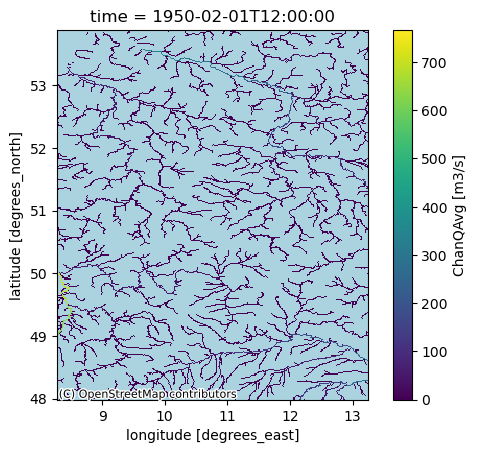

In [ ]:
# import contextily as ctx
# fig, ax = plt.subplots()

# dsplot = discharge.isel(time = 2)
# dsplot.dis.plot(ax = ax)
# # overlay the catchment boundary
# basin.plot(ax = ax, facecolor = 'none', edgecolor = 'blue', color = 'cyan', alpha = 0.5)

# ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)


